# PIT for Conditional Flows
Project idea based on [this paper](https://arxiv.org/abs/2102.10473). 

Using the `nflows` library for flow implementations.

In [1193]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import math

import torch.distributions as D
from scipy.stats import multivariate_normal, norm

from nde.train import train
from nde.flows import construct_maf
from plot import plot_pdf_1D


## CONTEXT (1D)

Consider the 1D conditional target distribution $f_{\Theta\mid X}$ with **unknown density** and we have **no samples**.

We only have access to samples from the joint distribution $f_{X,\Theta}$: $\quad (\Theta_1,X_1), \dots, (\Theta_n, X_n) \sim f_{X,\Theta}$

Our estimator $f_{Q\mid X}$ is a *Normalizing Flow* whose density is **explicitly known**. It is defined by a base distribution $p_U$ (tipically gaussian) and a bijective transformation $T_{\phi}$: 
$$U\sim p_U \rightarrow Q=T_{\phi}(U, X) \sim f_{Q\mid X}$$ 
$$f_{Q\mid X}(q) = p_{U}\left(T_{\phi}^{-1}(q, X)\right)\left|\operatorname{det} J_{T_{\phi}^{-1}}(q, X)\right|$$ 

Note that we can also define it's c.d.f. explicitly for a fixed $X=x_0$: $\quad F_{Q\mid X=x_0}(q) = \mathbb{P}(Q\leq q \mid X=x_0) =\mathbb{P}(T_{\phi}(U, x_0)\leq q)=\mathbb{P}(U\leq T_{\phi}^{-1}(q, x_0))=F_U(T_{\phi}^{-1}(q, x_0))$

We wish to know evaluate our estimator, with the same method as in the non-conditional case, i.e. with the PIT:

$$\text{PIT}(\theta, x ; f_{Q\mid X}) = \mathbb{P}(Q\leq \theta \mid X=x) = F_{Q \mid X=x}(\theta)$$

## EVALUATION
### True PIT-distribution / Local Consistency
For a fixed $X = x_0$ and $\Theta \sim f_{\Theta \mid X=x_0}$:
$$\begin{aligned} 
f_{Q\mid x_0} = f_{\Theta\mid x_0} & \iff \text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \sim \mathcal{U}(0,1)\\
& \iff \mathbb{P}_{\Theta \mid x_0}(\text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \leq \alpha) = \alpha, \quad \forall \alpha \in [0,1]\\
& \iff F_{\Theta \mid X=x_0}(F_{Q \mid X=x_0}^{-1}(\alpha)) = \alpha, \quad \forall \alpha \in [0,1]
\end{aligned}$$

We find ourselves with the same result as in the non-conditional 1D case , as $X$ is fixed at $x_0$ (cf. Theorem 2 in paper). 

**Problem:** We are unable to compute the c.d.f. of the target distribution $F_{\Theta \mid X=x_0}$, as the density $f_{\Theta \mid x_0}$ is unknown and no samples $\theta_i \mid x_0$ are available to approximate it empirically.

### Expected PIT-distribution over $X$ / Global Consistency 
We can however compute the empirical **expected c.d.f. over $X$** by using the samples from the joint distribution. 

$$\begin{aligned}
\mathbb{E}_X[F_{\Theta\mid X}(F_{Q\mid X}(\alpha)^{-1})] & = \mathbb{E}_X[\mathbb{P}_{\Theta\mid X}(F_{Q\mid X}(\Theta)\leq \alpha)]\\
& = \mathbb{E}_X[\mathbb{E}_{\Theta\mid X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]]\\
& = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]\\
& \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}
\end{aligned}$$

This gives us an approximation of the **expected (or joint) PIT-distribution:** 

$$\mathbb{E}_X[\mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha)] = \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}] \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}$$

#### Result 1: 
It is still true that if $\forall X, f_{Q\mid X} = f_{\Theta\mid X} $ (global consistency) and $\Theta, X \sim f_{\Theta, X}$, the *joint PIT-distribution* is uniform:

$$f_{Q\mid X} = f_{\Theta\mid X} \Rightarrow \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) =\alpha, \quad \forall \alpha \in [0,1]$$

**Problem:** The reverse is not true! This quantity does not allow us to evaluate our estimator (i.e. check global concistency) in a reliable way: we can find globally non-consistent estimators ($f_{Q\mid X} \neq f_{\Theta\mid X}$), but whose joint PIT-distribution is uniform. 

#### Result 2: 
Uniformity of the expected PIT-distribution holds for any estimator $f_{Q\mid X} = f_{\Theta\mid g(X)}$ with $g$ a given function (cf. Theorem 1 in paper).

#### Proofs can be found [here](https://notes.inria.fr/s/rhHwKKzaK).

### Global vs. Local Consistency: Illustration via Code 

Let's look at some code to illustrate this.

We consider a target density $\Theta\mid X \sim \mathcal{N}(X_1+X_2, 1)$ with $X = (X_1, X_2) \sim \mathcal{N}(\mu, \Sigma)$ where $\mu = [\mu_1, \mu_2]$ and $\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.



#### DATA Generation of Toy-model


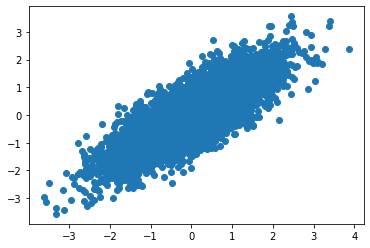

In [982]:
# Distribution parameters
mu_1 = 0
mu_2 = 0
sigma_1 = 1
sigma_2 = 1
rho = 0.8

# Distribution of X: 2d gaussian
mean = np.array([mu_1, mu_2])
covariance = np.array(
    [[sigma_1**2, rho * sigma_1 * sigma_2], [rho * sigma_1 * sigma_2, sigma_2**2]]
)
x_dist = multivariate_normal(mean=mean, cov=covariance)

# Samples from the joint distribution P(Theta,X) = P(X)*P(Theta|X)
n = 5_000  # nb samples


def get_joint_data(n):
    # samples from P(X)
    samples_x = x_dist.rvs(n)
    # samples from P(Theta|X)
    samples_theta = np.array([norm(loc=x[0] + x[1], scale=1).rvs(1) for x in samples_x])
    return samples_x, samples_theta


samples_x, samples_theta = get_joint_data(n=n)

# plot X-distribution
plt.scatter(samples_x[:, 0], samples_x[:, 1])
plt.show()


#### Result 1: Uniformity of the expected PIT-distribution

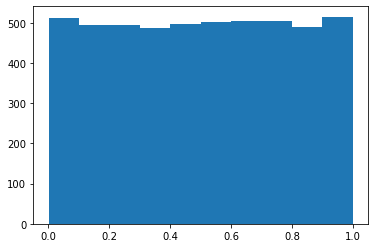

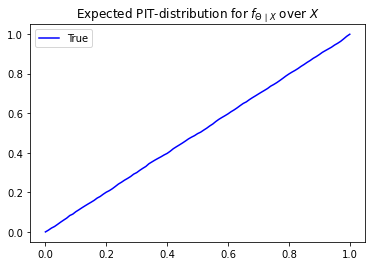

In [1195]:
# PLOT EXPECTED PIT-DISTRIBUTION for the true distribution Theta|X

# [PIT(Theta_i, X_i, f_{Theta|X})]
Z = np.array(
    [
        norm.cdf(samples_theta[i], loc=x[0] + x[1], scale=1)
        for i, x in enumerate(samples_x)
    ]
)

# Plot histogram of expected PIT-distribution
plt.hist(Z)
plt.show()

# PP-plot of expected PIT-distribution
alphas = np.linspace(0, 0.999, 101)
z_true = [
    np.mean(Z[:, 0] < alpha) for alpha in alphas  # quantiles [P_X,Theta(Z < alpha)]
]
plt.plot(alphas, z_true, color="blue", label="True")
plt.legend()
plt.title(r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$")
plt.show()


#### Result 2: Uniformity of globally non-consistent estimators
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

In [984]:
# Get train, val and test samples:
# - train samples are used to train the flow,
# - test samples are used to compute/learn the PIT-distribution

# Convert to pytorch tensors
samples_x, samples_theta = torch.FloatTensor(samples_x), torch.FloatTensor(
    samples_theta
)

# Split in train/test sets
test_size = int(0.1 * len(samples_theta))
train_size = len(samples_theta) - test_size
x_train, x_test = samples_x[:train_size], samples_x[train_size:]
theta_train, theta_test = samples_theta[:train_size], samples_theta[train_size:]

print("NB training samples: ", x_train.shape)
print("NB test samples: ", x_test.shape)


NB training samples:  torch.Size([4500, 2])
NB test samples:  torch.Size([500, 2])


In [985]:
# TRAIN FLOWS

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=False
)

# ... trained on X=(X_1,X_2)
best_val_loss_good, epochs_good = train(
    maf_good,
    theta_train,
    context=x_train,  # X=(X_1,X_2)
    num_epochs=2000,
    batch_size=10,
    lr=0.005,
    validation=True,
    plot=False,
    epochs_until_converge=20,
)

# Bad MAF...
maf_bad = construct_maf(
    theta_train, hidden_features=50, context_features=1, standardize_transform=False
)

# trained on g(X)=(X_1)
best_val_loss_bad, epochs_bad = train(
    maf_bad,
    theta_train,
    context=x_train[:, 0].reshape(-1, 1),  # g(X)=(X_1)
    num_epochs=2000,
    batch_size=10,
    lr=0.005,
    validation=True,
    plot=False,
    epochs_until_converge=20,
)


##### Global Consistency

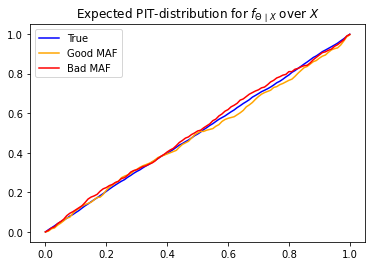

In [1060]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators

# CDF function of a (conditional) flow evaluated in x: F_{Q|context}(x)
cdf_flow = lambda x, context, flow: D.Normal(0, 1).cdf(
    flow._transform(x, context=context)[0]
)

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
Z_maf_good = np.array(
    [
        cdf_flow(theta_test[i][None], context=x, flow=maf_good).detach().numpy()
        for i, x in enumerate(x_test)
    ]
)

# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
Z_maf_bad = np.array(
    [
        cdf_flow(theta_test[i][None], context=x, flow=maf_bad).detach().numpy()
        for i, x in enumerate(x_test[:, 0].reshape(-1, 1))
    ]
)

# PP-plot of expected PIT-distribution for both flows
# Compute alpha-quantiles [P_X,Theta(Z < alpha)]
alphas = np.linspace(0, 0.999, 101)
z_maf_good = [np.mean(Z_maf_good[:, 0] <= alpha) for alpha in alphas]
z_maf_bad = [np.mean(Z_maf_bad[:, 0] <= alpha) for alpha in alphas]
# Plot the quantiles as a function of alpha
plt.plot(alphas, z_true, color="blue", label="True")
plt.plot(alphas, z_maf_good, color="orange", label="Good MAF")
plt.plot(alphas, z_maf_bad, color="red", label="Bad MAF")
plt.legend()
plt.title(r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$")
plt.show()


Both estimators have uniform PIT-distribution, but the bad MAF is not globally consistent. 

Indeed, the code below will show that the bad MAF is locally inconsistent, which implies also that it cannot be globally consistent.

##### Local Consistency

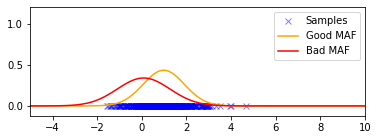

In [1196]:
# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])
samples_theta_x = torch.FloatTensor(
    norm(loc=x_0[:, 0] + x_0[:, 1], scale=1).rvs(test_size)
).reshape(-1, 1)

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good, x_0, "orange"), "Bad MAF": (maf_bad, x_0[:, 0], "red")}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)


We can already see that the two flows disagree. Espcially in the variance. 

This was not represented in the global pp-plot, but can be visualized via the local pp-plot (see code below).

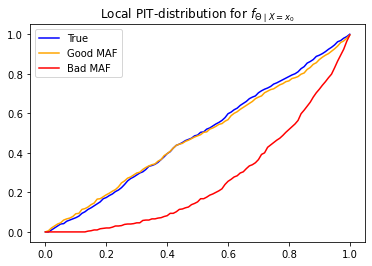

In [1148]:
# Local PIT-distribution on samples Theta_i from Theta|X=x_0

# Compute PIT-values [PIT(Theta_i, X=x_0, f_true/good/bad) = F_{Q|X_i}(Theta_i)]
Z_x = norm.cdf(samples_theta_x, loc=x_0[:, 0] + x_0[:, 1], scale=1)
Z_maf_good_x = cdf_flow(samples_theta_x, context=x_0, flow=maf_good).detach().numpy()
Z_maf_bad_x = (
    cdf_flow(samples_theta_x, context=x_0[:, 0], flow=maf_bad).detach().numpy()
)

# PP-plot of the local distribution
# Compute alpha-quantiles [P_{Theta|X}(Z < alpha)]
np.linspace(0, 0.999, 101)
z_true_x = [np.mean(Z_x[:, 0] <= alpha) for alpha in alphas]
z_maf_good_x = [np.mean(Z_maf_good_x[:, 0] <= alpha) for alpha in alphas]
z_maf_bad_x = [np.mean(Z_maf_bad_x[:, 0] <= alpha) for alpha in alphas]
# Plot the quantiles as a function of alpha
plt.plot(alphas, z_true_x, color="blue", label="True")
plt.plot(alphas, z_maf_good_x, color="orange", label="Good MAF")
plt.plot(alphas, z_maf_bad_x, color="red", label="Bad MAF")
plt.legend()
plt.title(r"Local PIT-distribution for $f_{\Theta \mid X=x_0}$")
plt.show()


Indeed, the variance distorsion of the bad MAF is clearly visible in this pp-plot (red line in S-shape). 

This shows that if our function $g(X)$ doas not caracterize covariate relations between the elements of $X$ (e.g. non-sufficient summary statistics), the expected PIT-distribution will not show us the error, whereas the local PIT-distribution does.

We need a way to claculate the local PIT-distribution! 

## Estimating the Local PIT-Distribution

We define the $\alpha$-quantile of the local PIT-distribution as follows:

$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}\mid X]$$

### Method proposed by [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473): 
**Regression of $W^{\alpha} = \mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}$ on $X$, using samples from the joint $(\Theta_i, X_i) \sim f_{\Theta, X}$.**

The goal is to estimate the random variable $W^{\alpha}$ as a function $f$ of $X$. 

Theoretically, the optimal solution of this regression problem - in terms of $L^2$-distance $E\left[(W^{\alpha} - f(X))^2\right]$ - is the conditional expectation $f^{\star}(X) = \mathbb{E}[W^{\alpha} \mid X] = r_{\alpha}(X)$ (it corresponds to the othogonal projection of $W^{\alpha}$ on $L^2(\Omega, \mathcal{F}(X), \mathbb{P}) = L^2_X$).

#### Algorithm:
1. pre-compute $W^{\alpha}_i$ using the avalable samples $\Theta_i, X_i$
2. regress $W^{\alpha}_i$ on $X_i$ to get an estimate of $r_{\alpha}(X)$
3. evaluate $r_{\alpha}$ in $X=x_0$
4. plot $r_{\alpha}(x_0)$ as a function of $\alpha$ and compare to identity

#### Comments
- This is actually a binary classifiacation problem 
- We need to use a regressor / classifier that has an optimum defined by the conditional expectation! Different loss function (i.e. classifiers) can be used (cf. [On Loss Functions Which Minimii to Conditional Expected Values and Posterior Probabilities](https://authors.library.caltech.edu/93850/1/00243457.pdf)). Here they use `sklearn.MLPClassifier` trained with a log-loss (compatible).
- There is a monotonic coupling / ordering between $r_{\alpha}(X)$ and $\alpha$: $r_{\alpha}(X) \nearrow \alpha$
    - cf. [isotonic regression with monotonic constraint in sklearn](https://scikit-learn.org/stable/modules/isotonic.html) (//calibration with binary target variable)
    - what about the multivariate case? cf. Random Forest for multi-output with monotonic splitting criteria?
    - implement existing method and analyse if monotonic or not in $\alpha$


### Implementation of the Regression Method from [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473):

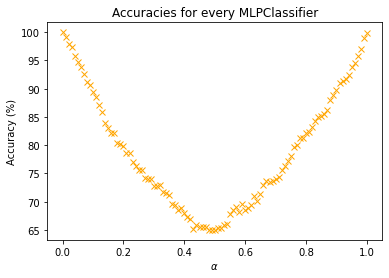

Mean training accuracy:  78.994


In [1160]:
# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyClassifier

# LogisticRegression(penalty='none', solver='saga', max_iter=10000)
# DummyClassifier()

# Training set for regression task: test set used for empirical approximations earlier
# Samples from the joint !
theta_train_PIT = theta_test
x_train_PIT = x_test

# Compute the PIT-values [PIT(Theta_i, X_i, flow)]
pit_values_train_good = np.array(
    [
        cdf_flow(theta_train_PIT[i][None], context=x, flow=maf_good).detach().numpy()
        for i, x in enumerate(x_train_PIT)
    ]
).ravel()
pit_values_train_bad = np.array(
    [
        cdf_flow(theta_train_PIT[i][None], context=x, flow=maf_bad).detach().numpy()
        for i, x in enumerate(x_train_PIT[:, 0].reshape(-1, 1))
    ]
).ravel()

# Algorithm:

# Define variables
alphas = np.linspace(0, 0.999, 101)  # alpha-values
pit_values_train = pit_values_train_bad  # pit-values used to compute the targets
x_eval = x_0.numpy()  # evaluation sample x_0

r_alpha_test = {}  # evaluated classifiers for each alpha
accuracies = {}  # accuracies for each classifier

# Estimate the local PIT-distribution quantiles
for alpha in alphas:
    W_a_train = (pit_values_train <= alpha).astype(int)  # compute the targets
    clf = MLPClassifier(alpha=0, max_iter=50000)
    # clf = DummyClassifier()
    clf.fit(X=x_train_PIT.numpy(), y=W_a_train)  # train classifier
    accuracies[alpha] = clf.score(x_train_PIT.numpy(), W_a_train) * 100
    # evaluate in x_0
    prob = clf.predict_proba(x_eval)
    if prob.shape[1] < 2:  # Dummy
        r_alpha_test[alpha] = prob[:, 0][0]
    else:  # MLPClassifier
        r_alpha_test[alpha] = prob[:, 1][0]

# Plot accuracies as a function of alpha
accuracies = pd.Series(accuracies)
accuracies.plot(style="x", color="orange")
plt.title(r"Accuracies for every MLPClassifier")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy (%)")
plt.show()
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))


Accuracy drops in the middle range between $\alpha = 0.2$ and $\alpha = 0.8$. 
But this is the range that interests us most! 
Indeed, at the extrems (0 and 1) it will always be 100% correct because only one class is present. 

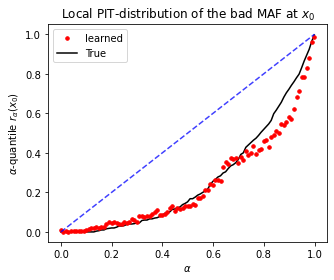

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.527
Mean training accuracy:  78.994


In [1161]:
# Local PP-plot
r_alpha_test = pd.Series(r_alpha_test)
fig = pd.Series(r_alpha_test).plot(
    style=".", color="red", figsize=(5, 4), markersize=7, label="learned"
)
plt.plot(alphas, z_maf_bad_x, color="black", label="True", zorder=0)
lims = [
    np.min([0, 0]),
    np.max([1, 1]),
]
plt.plot(lims, lims, "b--", alpha=0.75)
plt.ylabel(r"$\alpha$-quantile $r_{\alpha}(x_0)$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.title(r"Local PIT-distribution of the bad MAF at $x_0$")
plt.show()

# Evaluation metrics
euc_dist_to_gt = math.dist(z_maf_bad_x, list(r_alpha_test.values))
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))


In [1209]:
# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test) >= 0)
print(
    f"{monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)


68.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


Errors:
- logisticregressor doesnt work because needs 2 classes in training data. 
- Isotonic regression doesn't work because 'input X should be a 1d array or 2d array with 1 feature'. Anyway it should be increasing with alpha and not x.
- if including 1 in the alphas list, we get an outlier in the prediction

Comments:
- MLP trained for classification with the `log_loss`: $L_{\log }(y, p)=-(y \log (p)+(1-y) \log (1-p))$
- $p=$`predict_proba[:,1]` gives the probability of the **class $1$**, the success class of being $\leq \alpha$
- The classifiers are less accurate in the middle range, which is exactly what we expect: 
    - the goal is to plot the miscalibration of the probabilities, so it is normal that the accuracies drop for a miscalibrated problem: **Accuracy is not the right metric here!** 
    - cf. comparison to `Dummy` whose accuracy drops to $0.5$ at $\alpha = 0.5$ (linear function)


### Amortized in alpha 

**Idea: Only one Classifier on alpha and X:**
- can make relationship between r_alpha and alpha explicit and thus learn the monotonic constraint? 
- converges to what theoretically?

#### Method 2: 
Expand the training-set to take into account all ${\alpha_t}$ $\in$ `np.linspace(0,1,T)`:
- new targets: $W^{\alpha_t}_i$ for all $\alpha_t$ and $(\Theta_i, X_i)$
- new features **including $\alpha$**: $\{(X_0,\alpha_t), \dots, (X_n,\alpha_t)\}$ for all $\alpha_t$

The size is multiplied by the number $T$ of $\alpha$-values (here $T=101$)


In [1188]:
# Train the Classifier amortized on x and all alpha

# train features: all alpha and x
x_train_alphas = np.array([i for i in x_train_PIT.numpy()] * 101)
alphas_train = np.linspace(0, 0.999, 101).repeat(test_size).reshape(-1, 1)
train_features_all = np.concatenate([x_train_alphas, alphas_train], axis=1)

# train labels W_alpha(z)
W_a_train_all = []
alphas = np.linspace(0, 0.999, 101).reshape(-1, 1)
for alpha in alphas:
    W_a_train_all.append(np.array([1 * (z <= alpha) for z in pit_values_train]))
W_a_train_all = np.array(W_a_train_all).flatten()

# define and train classifier
# from sklearn.ensemble import HistGradientBoostingClassifier
# clf = HistGradientBoostingClassifier(monotonic_cst=[0, 0, 1], max_iter=10)
clf = MLPClassifier(alpha=0.0, max_iter=500)
clf.fit(X=train_features_all, y=W_a_train_all)  # train classifier
train_accuracy = clf.score(train_features_all, W_a_train_all.ravel()) * 100


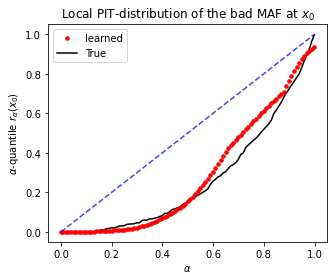

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.52
Training accuracy:  80.634


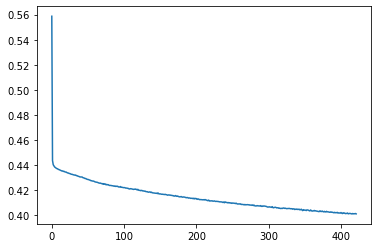

In [1212]:
# Evaluate in x_0 and for all alphas in [0,1]
r_alpha_test_all = {}
for alpha in np.linspace(0, 0.999, 101):
    test_features = np.concatenate([x_eval, np.array(alpha).reshape(-1, 1)], axis=1)
    r_alpha_test_all[alpha] = clf.predict_proba(test_features)[:, 1][0]

# Local PP-Plot
r_alpha_test_all = pd.Series(r_alpha_test_all)
fig = r_alpha_test_all.plot(
    style=".", color="red", figsize=(5, 4), markersize=7, label="learned"
)
plt.plot(alphas, z_maf_bad_x, color="black", label="True", zorder=0)
lims = [
    np.min([0, 0]),
    np.max([1, 1]),
]
plt.plot(lims, lims, "b--", alpha=0.75)
plt.ylabel(r"$\alpha$-quantile $r_{\alpha}(x_0)$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.title(r"Local PIT-distribution of the bad MAF at $x_0$")
plt.show()

# Evaluation metrics
euc_dist_to_gt_all = math.dist(z_maf_bad_x, list(r_alpha_test_all.values))
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt_all, 3),
)
print("Training accuracy: ", np.round(train_accuracy, 3))

# Plot loss evolution
plt.plot(clf.loss_curve_)
plt.show()


In [1210]:
# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_all) >= 0)
print(
    f"{monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)


100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


#### Method 3:
Sample $\alpha \sim \mathcal{U}(0,1)$ $T=1$ time for each sample $(\Theta_i, X_i)$ of the joint. 

In [1149]:
# Train the Classifier amortized on x and sampled alpha

# train features: sampled alpha and x
alphas_sample = np.random.rand(test_size).reshape(-1, 1)  # sample one alpha for each x
train_features_sample = np.concatenate([x_train_PIT.numpy(), alphas_sample], axis=1)

# train labels W_alpha(z)
W_a_train_sample = np.array(
    [1 * (z <= alphas_sample[i]) for i, z in enumerate(pit_values_train)]
)

# define and train classifier
clf = MLPClassifier(alpha=0, max_iter=50000)
clf.fit(X=train_features_sample, y=W_a_train_sample.ravel())  # train classifier
train_accuracy_sample = clf.score(train_features_sample, W_a_train_sample.ravel()) * 100


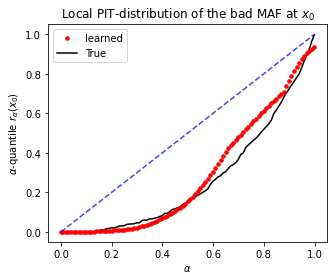

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.52
Training accuracy:  81.2


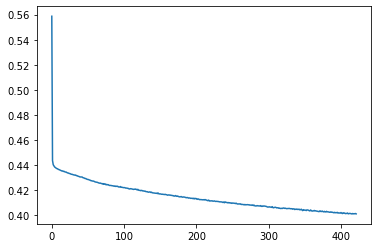

In [1213]:
# Evaluate in x_0 and for all chosen alphas in [0,1]
r_alpha_test_sample = {}
for alpha in np.linspace(0, 0.999, 101):
    test_features = np.concatenate([x_eval, np.array(alpha).reshape(-1, 1)], axis=1)
    r_alpha_test_sample[alpha] = clf.predict_proba(test_features)[:, 1][0]


# Local PP-Plot
r_alpha_test_sample = pd.Series(r_alpha_test_sample)
fig = r_alpha_test_sample.plot(
    style=".", color="red", figsize=(5, 4), markersize=7, label="learned"
)
plt.plot(alphas, z_maf_bad_x, color="black", label="True", zorder=0)
lims = [
    np.min([0, 0]),
    np.max([1, 1]),
]
plt.plot(lims, lims, "b--", alpha=0.75)
plt.ylabel(r"$\alpha$-quantile $r_{\alpha}(x_0)$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.title(r"Local PIT-distribution of the bad MAF at $x_0$")
plt.show()

# Evaluation Metrics
euc_dist_to_gt_sample = math.dist(z_maf_bad_x, list(r_alpha_test_sample.values))
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt_sample, 3),
)
print("Training accuracy: ", np.round(train_accuracy_sample, 3))

# Plot loss evolution
plt.plot(clf.loss_curve_)


In [1214]:
# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_sample) >= 0)
print(
    f"{monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)


100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


**Comments:**

- The original method needs multiple classifiers (one for each alpha value) is not verifying the monotonic constraint. 
- The in alpha amortized versions insure that the monotonic constrain is respected. BUT depending on the $x_0$ used for evaluation, the amortized versions can be pretty far from the black groundtruth (euclidean distance). 
- We could increase $T$ for method 3 (e.g. $T=20$).
- Accuracy is not the right metric! 
- We should compare the results in one plot: distance to GT (black curve), computational time, number of training samples needed (alpha samples during training and features...)

**TODO:**
- Evaluate the variance of the methods over several trainings of a model evaluated in the same $x_0$ (model uncertainty)
- Evaluate the variance of the methods over several choices of $x_0$ (data uncertainty)
- Plots to visualize comparisons between methods:
    - distance to ground-truth
    - computational cost
    - number of training samples needed
    
Small checks:
- Compare to `LogisticRegression`
- See convergence criteria of `MLPClassifier`
- confidence intervals like in paper code? 
- add constraint (bounds (0,1)?)
- regularize?


